<a href="https://colab.research.google.com/github/hwangsae91/project_so/blob/master/exploration/221018/%5BExp_10%5D20221018.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# google colab전용
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# exploration 10번째 과제
@ 황한용(3기/쏘카)

## 라이브러리 선언

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import re
import string # 구두점 정규화 표현식
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Masking
from tensorflow.keras.models import Model

`tensorflow.keras.preprocessing.sequence.pad_sequences`는 모듈 위치가 변경되었으므로
`tf.keras.utils.pad_sequences`로 변경<br>

## 상수선언

In [3]:
BASE_PATH = "/content/drive/MyDrive/Colab Notebooks/data/translator_seq2seq" # 데이터 기본경로
DATA_PATH  = BASE_PATH + "/data/fra.txt" # 사전 기본

SOS_TOKEN = '<sos>' # 문장 시작토큰
EOS_TOKEN = '<eos>' # 문장 끝 토큰

MAX_SAMPLE_LEN = 55000 # 최대 단어갯수
VALID_LEN = 5000 # 검증할 문장의 갯수
PUNCTUATION_REGEX = r'[\!\"\#\$\%\&\'\(\)\*\+\,\-\.\/\:\;\<\=\>\?\@\[\\\]\^\_\`\{\|\}\~]' # 정규화
FRENCH_WHITESPACE = r'[\xa0\u202f\u2009]' # whitespace 정규화(1/4 whitespace 등의 대응)
FRENCH_APOSTROPHE = r"’" # 프랑스어 '
FRENCH_DOUBLE_COMMA = r"'<<|>>'" # 프랑스어 "
FRENCE_MINUS_REGEX = r"\—" # 프랑스어 -

pad_seq_kwargs = {
    "value":None # 추후 추가예정
    , "padding":"post"
    , "maxlen":None # 추후 추가예정
}
TRAIN_TEST_SPLIT_KWARGS = {
    "test_size":0.08, "random_state":2022
}

HIDDEN_STATE_NUM = 64 # hidden state의 노드수

fit_kwargs = {
    "epochs":50 # epoch 횟수
    , "batch_size":HIDDEN_STATE_NUM
    ,"validation_data": None # 추후 추가예정
    , "shuffle" : True # epoch당 셔플을 할지의 여부
    , "verbose":1
}

영어의 경우는 `string.punctuation`의 구두점을 활용하여 만들었다.<br>
프랑스어의 경우는 문법에 따라 1/8, 1/4, 1/2 `whitespace`를 표준`whitespace`로 변경하였으며<br>
`'`, `"`, `-` 또한 표준으로 변경하였다.<br>
알파벳의 악쌍(악센트, 성조)은 단어의 의미를 결정하는 요소이므로 제거하지 않았다.

## 메인

### 전처리

In [4]:
lines = pd.read_csv(DATA_PATH, names=['eng', 'fra', 'cc'], sep='\t')
print('전체 샘플의 수 :',len(lines))
lines.sample(5) #샘플 5개 출력
lines.pop('cc')
lines = lines.head(MAX_SAMPLE_LEN)

전체 샘플의 수 : 197463


데이터에 대한 설명은 아래와 같다.</br>
- eng: 영어문장
- fra: 영어 문장에 해당되는 프랑스 문장
- cc: 저작권 정보

저작권 정보는 데이터 분석에 사용되지 않으므로 로드하지 않았다.

In [5]:
# 구두점(Punctuation)을 단어와 분리
# 프랑스 문법에만 존재하는 whitespace -> 표준 whitespace로 변경
lines["fra"] = lines["fra"].str.replace(FRENCH_WHITESPACE, r' ', regex=True)
#프랑스 문법에만 존재하는 ’를 '로 변경
lines["fra"] = lines["fra"].str.replace(FRENCH_APOSTROPHE, r"'", regex=True)
# 프랑스 문법에만 존재하는 <<, >>를 "로 변경
lines["fra"] = lines["fra"].str.replace(FRENCH_DOUBLE_COMMA, r'"', regex=True)
# 프랑스 문법에만 존재하는 —를 -로 변경
lines["fra"] = lines["fra"].str.replace(FRENCE_MINUS_REGEX, r"-", regex=True)

# 구분점에 whitespace를 지음
lines["fra"] = lines["fra"].str.replace(PUNCTUATION_REGEX, r' \g<0> ', regex=True).replace(' +', ' ', regex=True).str.strip()
lines["eng"] = lines["eng"].str.replace(PUNCTUATION_REGEX, r' \g<0> ', regex=True).replace(' +', ' ', regex=True).str.strip()
lines["fra"] = lines["fra"].str.replace(' +', ' ', regex=True)
lines["eng"] = lines["eng"].str.replace(' +', ' ', regex=True)

lines["fra_decoder_input"] = f'{SOS_TOKEN} '+ lines["fra"]
lines["fra_decoder_target"] = lines["fra"] + f' {EOS_TOKEN}'
lines["fra"] = f'{SOS_TOKEN} '+ lines["fra"] + f' {EOS_TOKEN}' # 양옆에 문장의 시작과 끝의 테그를 붙인다.

lines["eng"] = lines["eng"].str.split()

lines["fra"] = lines["fra"].str.split()
lines["fra_decoder_input"] = lines["fra_decoder_input"].str.split()
lines["fra_decoder_target"] = lines["fra_decoder_target"].str.split()

eng_tokenizer = Tokenizer(filters="")  # 문자 단위로 Tokenizer를 생성 
eng_tokenizer.fit_on_texts(lines["eng"])
encoder_input = eng_tokenizer.texts_to_sequences(lines["eng"])

fra_tokenizer = Tokenizer(filters="")
fra_tokenizer.fit_on_texts(lines["fra"])

decoder_input = fra_tokenizer.texts_to_sequences(lines["fra_decoder_input"])
decoder_target = fra_tokenizer.texts_to_sequences(lines["fra_decoder_target"])

eng_vocab_size = len(eng_tokenizer.word_index) + 1
fra_vocab_size = len(fra_tokenizer.word_index) + 1
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)

max_eng_seq_len = max(map(len, encoder_input))
max_fra_seq_len = max(map(len, decoder_input))
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

영어 단어장의 크기 : 6386
프랑스어 단어장의 크기 : 11450
영어 시퀀스의 최대 길이 11
프랑스어 시퀀스의 최대 길이 19


영어문장와 프랑스문장를 각각 tokenize한 뒤<br>
단어 사전의크기, 한 문장의 최대 단어 갯수를 확인<br>
이 데이터는 후에 padding에 사용할 예정이다.<br>
문장의 끝 토큰이 제거된 input과<br>
문장의 시작 토큰이 제거된 output을 각각 데이터 프레임에서 생산하였으며<br>
이번에는 구두점도 임배딩에 필요하므로 필터옵션을 통해 없어지지 않도록 설정하였다.<br>

In [6]:
encoder_input = pad_sequences(encoder_input, maxlen = max_eng_seq_len, padding='post')
decoder_input = pad_sequences(decoder_input, maxlen = max_fra_seq_len, padding='post')
decoder_target = pad_sequences(decoder_target, maxlen = max_fra_seq_len, padding='post')
print('영어 데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 데이터의 크기(shape) : (55000, 11)
프랑스어 입력데이터의 크기(shape) : (55000, 19)
프랑스어 출력데이터의 크기(shape) : (55000, 19)


각 언어의 최대 단어갯수에 맞춰 padding을 생성하였다.<br>
(`문장의 갯수`,`각 언어의 문장당 단어 최대갯수`)모양의 데이터가 생성되었다.


In [7]:
shuffle_idx  = np.arange(MAX_SAMPLE_LEN)
np.random.shuffle(shuffle_idx)

encoder_input = encoder_input[shuffle_idx]
decoder_input = decoder_input[shuffle_idx]
decoder_target = decoder_target[shuffle_idx]

print(encoder_input[3])
print(decoder_input[3])
print(decoder_target[3])

encoder_input_train = encoder_input[:-VALID_LEN]
decoder_input_train = decoder_input[:-VALID_LEN]
decoder_target_train = decoder_target[:-VALID_LEN]

encoder_input_test = encoder_input[-VALID_LEN:]
decoder_input_test = decoder_input[-VALID_LEN:]
decoder_target_test = decoder_target[-VALID_LEN:]

[167   8 135   1   0   0   0   0   0   0   0]
[  1 243  23 263  18   0   0   0   0   0   0   0   0   0   0   0   0   0
   0]
[243  23 263  18   2   0   0   0   0   0   0   0   0   0   0   0   0   0
   0]


과적합 방지를 위해 학습과 점증을 10:1비율로 나누었다. 

### 모델 설계

In [8]:
encoder_inputs = Input(shape=(None,))
encoder_embadding = Embedding(eng_vocab_size, HIDDEN_STATE_NUM)
encoder_masking = Masking(mask_value=0.0)(encoder_embadding(encoder_inputs))
encoder_lstm = LSTM(units=HIDDEN_STATE_NUM, return_state = True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_masking)
encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(None, ))
decoder_embadding = Embedding(fra_vocab_size, HIDDEN_STATE_NUM)
decoder_masking = Masking(mask_value=0.0)(decoder_embadding(decoder_inputs))
decoder_lstm = LSTM(units=HIDDEN_STATE_NUM, return_sequences = True, return_state=True)
decoder_outputs, _, _= decoder_lstm(decoder_masking, initial_state = encoder_states)

decoder_softmax_layer = Dense(fra_vocab_size, activation='softmax')
decoder_outputs = decoder_softmax_layer(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.005)
    , loss="sparse_categorical_crossentropy", metrics=['acc']
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 64)     408704      ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, None, 64)     732800      ['input_2[0][0]']                
                                                                                              

encorder는 영어를 프랑스어로 번역하기 위한 레이어이므로<br>영어 최대길이를 input으로 프랑스어 최대길이를 output으로 크기를 설정하였고<br>decorder는 프랑스어가 번역된 것을 검증하기 위한 레이어이므로 입력, 출력 모두 프랑스어에 맞게 설정하였다.

Epoch 1/50
782/782 [==============================] - 25s 20ms/step - loss: 1.6433 - acc: 0.7518 - val_loss: 1.1644 - val_acc: 0.8089
Epoch 2/50
782/782 [==============================] - 14s 17ms/step - loss: 1.0146 - acc: 0.8281 - val_loss: 0.9390 - val_acc: 0.8403
Epoch 3/50
782/782 [==============================] - 13s 17ms/step - loss: 0.8162 - acc: 0.8506 - val_loss: 0.8166 - val_acc: 0.8542
Epoch 4/50
782/782 [==============================] - 13s 17ms/step - loss: 0.6874 - acc: 0.8649 - val_loss: 0.7505 - val_acc: 0.8628
Epoch 5/50
782/782 [==============================] - 13s 17ms/step - loss: 0.5968 - acc: 0.8752 - val_loss: 0.7116 - val_acc: 0.8680
Epoch 6/50
782/782 [==============================] - 13s 17ms/step - loss: 0.5280 - acc: 0.8838 - val_loss: 0.6829 - val_acc: 0.8719
Epoch 7/50
782/782 [==============================] - 13s 17ms/step - loss: 0.4729 - acc: 0.8914 - val_loss: 0.6636 - val_acc: 0.8753
Epoch 8/50
782/782 [==============================] - 13s 17ms

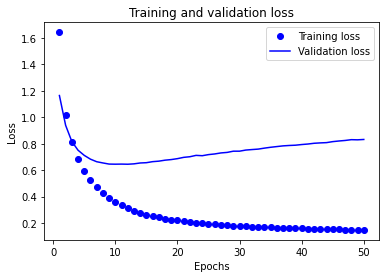

In [9]:
fit_kwargs["validation_data"] = ([encoder_input_test, decoder_input_test], decoder_target_test)

history_dict = model.fit(
                         x=[encoder_input_train, decoder_input_train]
                         , y=decoder_target_train
                         , **fit_kwargs).history

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epoch = range(1, len(loss) + 1)

plt.plot(epoch, loss, 'bo', label='Training loss')
plt.plot(epoch, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

학습결과 우하향하는 그래프의 모습을 보이며 train loss, validation loss 의 차이가 크지않다.

### 검증


In [10]:
encoder_model = Model(inputs = encoder_inputs, outputs = encoder_states)
encoder_model.summary()

# 이전 time step의 hidden state를 저장하는 텐서
decoder_state_input_h = Input(shape=(HIDDEN_STATE_NUM,))
# 이전 time step의 cell state를 저장하는 텐서
decoder_state_input_c = Input(shape=(HIDDEN_STATE_NUM,))
# 이전 time step의 hidden state와 cell state를 하나의 변수에 저장
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_embadding_val = decoder_embadding(decoder_inputs)

# decoder_states_inputs를 현재 time step의 초기 상태로 사용.
# 구체적인 동작 자체는 def decode_sequence()에 구현.
decoder_outputs_val, state_h, state_c = decoder_lstm(decoder_embadding_val, initial_state = decoder_states_inputs)
# 현재 time step의 hidden state와 cell state를 하나의 변수에 저장.
decoder_states_val = [state_h, state_c]

decoder_outputs_val = decoder_softmax_layer(decoder_outputs_val)
decoder_model = Model(inputs=[decoder_inputs] + decoder_states_inputs, outputs=[decoder_outputs_val] + decoder_states_val)
decoder_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 64)          408704    
                                                                 
 masking (Masking)           (None, None, 64)          0         
                                                                 
 lstm (LSTM)                 [(None, 64),              33024     
                              (None, 64),                        
                              (None, 64)]                        
                                                                 
Total params: 441,728
Trainable params: 441,728
Non-trainable params: 0
_________________________________________________________________
Model: "model_2"
____________________________________

In [11]:
eng2idx = eng_tokenizer.word_index
fra2idx = fra_tokenizer.word_index
idx2eng = eng_tokenizer.index_word
idx2fra = fra_tokenizer.index_word

In [12]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    states_value = encoder_model.predict(input_seq)

    # <SOS>에 해당하는 원-핫 벡터 생성
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = fra2idx[SOS_TOKEN]

    stop_condition = False
    decoded_sentence = ""

    # stop_condition이 True가 될 때까지 루프 반복
    while not stop_condition:
        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # 예측 결과를 문자로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = idx2fra[sampled_token_index]

        # 현재 시점의 예측 문자를 예측 문장에 추가
        decoded_sentence += " " + sampled_char

        # <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_char == EOS_TOKEN or
           len(decoded_sentence) > 50):
            stop_condition = True

        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [h, c]

    return decoded_sentence

In [13]:
sample = 10
input_seq = encoder_input_train[sample: sample + 1]
decoded_sentence = decode_sequence(input_seq)
print("-" * 35)

print("입력문장 :", "".join([
        idx2eng[encoded_word] + " "
        for encoded_word in encoder_input_train[sample]
        if encoded_word != 0
    ])
)
print("정답문장 :",  "".join([
      idx2fra[encoded_word] + " "
      for encoded_word in decoder_input_train[sample]
      if encoded_word != 0 and encoded_word != fra2idx[SOS_TOKEN] and encoded_word != fra2idx[EOS_TOKEN]
  ])
)

print("번역문장 :",decoded_sentence)
print("-" * 35)

sample = 10
input_seq = encoder_input_test[sample: sample + 1]
decoded_sentence = decode_sequence(input_seq)
print("-" * 35)

print("입력문장 :", "".join([
        idx2eng[encoded_word] + " "
        for encoded_word in encoder_input_test[sample]
        if encoded_word != 0
    ])
)
print("정답문장 :",  "".join([
      idx2fra[encoded_word] + " "
      for encoded_word in decoder_input_test[sample]
      if encoded_word != 0 and encoded_word != fra2idx[SOS_TOKEN] and encoded_word != fra2idx[EOS_TOKEN]
  ])
)

print("번역문장 :",decoded_sentence)
print("-" * 35)

1/1 [==============================] - 0s 17ms/step
-----------------------------------
입력문장 : it ' s warmer . 
정답문장 : c ' est plus chaud . 
번역문장 :  c ' est plus chaud . <eos>
-----------------------------------
1/1 [==============================] - 0s 17ms/step
-----------------------------------
입력문장 : help me . 
정답문장 : aide - moi . 
번역문장 :  aide - moi ! <eos>
-----------------------------------


### 회고


- 학습된 데이터가 전체적으로 높은 정확도를 보여 미리 학습된 데이터의 중요성을 알게되었다.
- 항상 학습된 데이터가 높은 정확도를 나타내는 것이 아니라 하이퍼파라미터의 튜닝에 따라 결과가 달라질 수 있다는 것을 알게 되었다.

※ 이번 레포트는 양희성님의 모델구조의 조언으로 작성되었음을 알려드립니다.<br>
   희성님에게 감사하다는 글을 남기며 이만 글을 마치겠습니다.